# Example 2: Perform analysis on a specific segment

This Example will show how the library can be used to handle area-of-interest analysis.
In this example, we have an OCTA scan with a predefined foveal avascular zone and some area of interest.
We will create a ring segment concentric to the fovea and an adjacent tissue control.
In the end, we visualize this data.

These exemplary areas could be used as segments for VAD analysis, as shown in example 1.


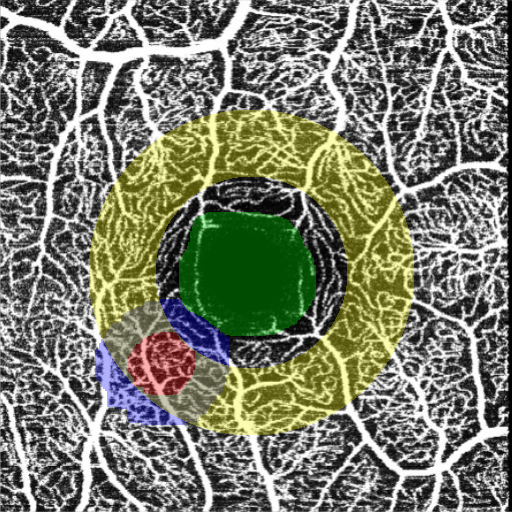

In [7]:
import numpy as np
import matplotlib as plt
import OpenOCTAAnalyzer as octa
import pickle
from IPython.display import display
from PIL import Image

def render_nifti(vol, seg, extra_mask = None, output_file="", alpha=0.7):
    if np.ndim(vol) == 3:
        # OCT
        # Load OCT slice at the center of the volume
        this_slice = (vol.shape[2] - 1) // 2
        z_slice = vol[:, :, this_slice]  # Select 2D image in the middle of the OCT volume

        # Create output image
        output_image = np.stack([z_slice] * 3, axis=-1)  # Create RGB image

        mask_1 = (seg[:, :, 12] == 1)
        mask_2 = (seg[:, :, 12] == 2)
        mask_3 = (seg[:, :, 12] == 3)
        mask_4 = (seg[:, :, 12] == 4)
        mask_5 = (seg[:, :, 12] == 5)
    else:
        z_slice = vol.astype(int)
        seg = seg.astype(int)
        output_image = np.stack([z_slice] * 3, axis=-1)
        #seg = np.tile(seg, (1, 1, 3))

        mask_1 = seg == 1# (seg[:, :] == 1)
        mask_2 = seg == 2# (seg[:, :] == 2)
        mask_3 = seg == 3# (seg[:, :] == 3)
        mask_4 = seg == 4# (seg[:, :] == 4)
        mask_5 = seg == 5# (seg[:, :] == 5)

    a2 = int(255 * (1 - alpha))

    output_image[mask_1] = alpha * output_image[mask_1] + [a2, 0, 0]
    output_image[mask_2] = alpha * output_image[mask_2] + [0, a2, 0]
    output_image[mask_3] = alpha * output_image[mask_3] + [0, 0, a2]
    output_image[mask_4] = alpha * output_image[mask_4] + [a2, a2, 0]
    output_image[mask_5] = alpha * output_image[mask_5] + [0, a2, a2]

    if extra_mask is not None:
        output_image[extra_mask] = alpha * output_image[extra_mask] + [a2, a2, 0]

    if output_file != "":
        plt.figure() 
        plt.imshow(output_image.astype(np.uint8))
        plt.savefig(output_file)

    return output_image

vol = octa.loadNifti('input/patient1/Patient1 OD SVP.nii')

# create an adjacent tissue control
octa.double_segmentation('input/patient1/example_lesion.nii.gz', 'input/patient1/example_lesion_processed.nii.gz', 1, 3)
seg = octa.loadSegmentation('input/patient1/example_lesion_processed.nii.gz')
with open('input/patient1/pos.pkl', 'rb') as f:
    pos = pickle.load(f)


extra_mask = octa.createRingSegmentation(seg, 1, pos['foveaPos']).astype(int)
extra_mask = extra_mask == 1
extra_mask[seg == 1] = False

output_image = render_nifti(vol, seg, extra_mask)

# Convert the NumPy array to a PIL Image
image_pil = Image.fromarray(output_image.astype(np.uint8))
display(image_pil)